# Language and Topic models

A common suggestion to users for coming up with good queries is to think of words that would likely appear in a relevant document, and to use those words as the query. The language modeling approach to IR directly models this idea: a document is a good match to a query if the document model is likely to generate the query, which will in turn happen if the document contains the query words often. 

Today we will score documents with respect to user query using language models and also get some experience with topic modelling.

## Loading data

In this class we will use the dataset we already used once - [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads).

In [0]:
!wget -O music.txt https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/topic-modeling-tool/testdata_news_music_2084docs.txt
!wget -O economy.txt https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/topic-modeling-tool/testdata_news_economy_2073docs.txt
!wget -O fuel.txt https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/topic-modeling-tool/testdata_news_fuel_845docs.txt
!wget -O brain.txt https://storage.googleapis.com/google-code-archive-downloads/v2/code.google.com/topic-modeling-tool/testdata_braininjury_10000docs.txt
#TODO read the dataset into list
import itertools
import pandas as pd
brain=[]
economy = []
music = []
fuel = []

bb = open('brain.txt', 'r')
for b in bb:
  brain.append(b)

ee = open("economy.txt", 'r')
for b in ee:
  economy.append(b)


mu = open("music.txt",'r')
for b in mu:
  music.append(b)

fu = open("fuel.txt",'r')
for b in fu:
  fuel.append(b)
all_data = list(itertools.chain(brain, economy, music, fuel))

## 1. Ranking Using Language Models
Our goal is to rank documents by *P(d|q)*, where the probability of a document is interpreted as the likelihood that it is relevant to the query. 

Using Bayes rule: *P(d|q) = P(q|d)P(d)/P(q)*

*P(q)* is the same for all documents, and so can be ignored. The prior probability of a document *P(d)* is often treated as uniform across all *d* and so it can also be ignored. What does it mean? 

It means that comparing *P(q|d)* between different documents we can compare how relevant are they to the query. How can we estimate *P(q|d)*?

*P(q|d)* can be estimated as:
![](https://i.imgur.com/BEIMAC1.png)

where M<sub>d</sub> is the language model of document *d*, tf<sub>t,d</sub> is the term frequency of term *t* in document *d*, and L<sub>d</sub> is the number of tokens in document *d*. That is, we just count up how often each word occurred, and divide by the total number of words in the document *d*. The first thing we need to do is to build a term-document matrix for tour dataset.

In [0]:
import nltk
nltk.download('all')
from nltk.tokenize import word_tokenize
tokenized_sents = [word_tokenize(i.lower()) for i in all_data]
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(all_data)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

### Smoothing

Now, you need to implement the abovementioned logic in the `lm_rank_documents` function below. Do you see any potential problems?

Yes, data sparsity - we don't expect to meet each term in each doc, so, in most cases, we will get zero scores, which is not what we really want.

The solution is smooting.

One option is *additive smoothing* - adding a small number (0 to 1) to the observed counts and renormalizing to give a probability distribution.

Another option is called Jelinek-Mercer smoothing - a simple idea that works well in practice is to use a mixture between a document-specific distribution and distribution estimated from the entire collection:

![](https://i.imgur.com/8Qv41Wp.png)

where 0 < λ < 1 and M<sub>c</sub> is a language model built from the entire document collection.

Refer to *Chapter 12* for the detailed explanation.


You are going to apply both in your `lm_rank_documents` function. This function takes as an input tdm matrix, and ranks all documents "building" a language model for each document, returning relative probabilities of query being generated by a document as a document's score.

In [0]:
import numpy as np

def lm_rank_documents(query, tdm = df, terms_list = tokenized_sents, smoothing='additive', param=0.001):
    tokenized = nltk.word_tokenize(query.lower())
    tokenized=set(tokenized)
    scores = []
    suma = df.values.sum()
    if smoothing == 'additive':
    # TODO: score each document in tdm using this document's language model
    # implement two types of smoothing. Looks up term frequencies in tdm
    # return document scores in a convenient form
    # param is alpha for additive / lambda for jelinek-mercer
      for numb,document in enumerate(terms_list):
        scop = 1
        unique = set ()
        for word in document:
          unique.add(word)
        for word in unique:
          if word in tokenized:
            scop = scop*df.at[numb,f'{word}']/len(document) + param
          else:
            scop =+ param
        scores.append(tuple([numb, scop]))
      
    else:
      for numb,document in enumerate(terms_list):
        scop = 1
        unique = set ()
        for word in document:
          unique.add(word)
        for word in unique:
          word_rarity = df[word].sum()/suma
          if word in tokenized:
            scop = scop*df.at[numb,f'{word}']/len(document) + word_rarity*(1-param)
          else:
            scop =+ word_rarity*(1-param)
        scores.append(tuple([numb, scop]))

    return sorted(scores, key=lambda x: x[1],reverse = True)

### Testing

Check if this type of ranking gives meaningful results. For each query output document category, doc_id, score, and the beginning of the document, as it is shown below. Analyze if categories and contents match the queries. 

In [70]:
def process_query(raw_query):
    scor = lm_rank_documents(raw_query, tdm = df, terms_list = tokenized_sents, smoothing='additive', param=0.001)
    # TODO: process user query and print search results including document category, id, score, and some part of it
    print ("user query:"+ raw_query)

    for g in range (5):
      z = scor[g][0]
      print('index',z)
      print('score',scor[g][1])
      print(all_data[z])
      if z<len(brain):
        print('text from :brain')
      elif z< len(brain)+len(economy):
        print('text from :economy')
      elif z< len(brain)+len(economy)+len(music):
        print('text from :music')
      else:
        print('text from :fuel')
      print("\n","\n")
    pass
    

user_queries = ["piano concert", "symptoms of head trauma", "wall street journal"]
for q in user_queries:
    process_query(q)
    print("\n")

user query:piano concert
index 0
score 0.001
therapeutic potential melatonin traumatic central nervous system injury vast literature extolling the benefits melatonin has accumulated during the past four decades melatonin was previously considered importance seasonal reproduction and circadian rhythmicity currently appears versatile anti oxidative and anti nitrosative agent molecule with immunomodulatory actions and profound oncostatic activity and also play role potent neuroprotectant nowadays melatonin sold dietary supplement with differential availability over the counter aid different countries there widespread agreement that melatonin nontoxic and safe considering its frequent long term usage humans both physiological and pharmacological doses with reported side effects endeavors toward designated drug status for melatonin may enormously rewarding clinics for treatment several forms neurotrauma where effective pharmacological intervention has not yet been attained this mini review 

## 2. Topic modeling

Now let's use *Latent Dirichlet Allocation* to identify topics in this collection and check if they match the original topics (fuel, economy, etc.). Go through the tutorial [here](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) and apply the ideas there to our dataset. 

In [38]:
# TODO: apply LDA to our dataset and output the resulting categories 


3

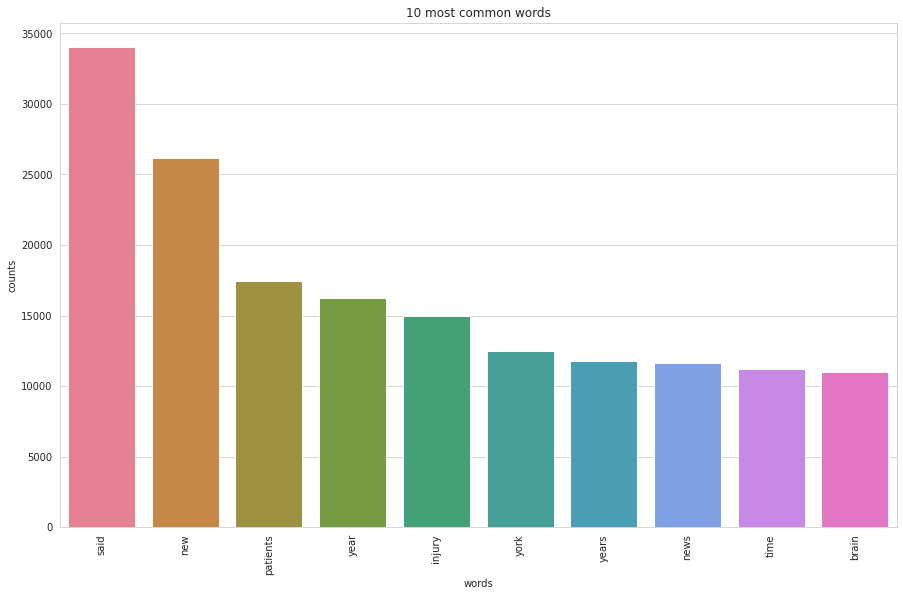

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(all_data)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [57]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
atlanta new news journal constitution york moved cox beach times

Topic #1:
new york music jan film like people life times words

Topic #2:
music says que like band album songs best just song

Topic #3:
said new year people bush enron percent company years time

Topic #4:
patients injury brain traumatic study tbi results injuries trauma head
